# Library

In [2]:
! pip install wandb opencv-python-headless==4.1.2.30 albumentations torch-summary timm einops joblib icecream  -qq -U

     |████████████████████████████████| 1.7 MB 24.8 MB/s 
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
     |████████████████████████████████| 102 kB 57.1 MB/s 
     |████████████████████████████████| 431 kB 72.0 MB/s 
     |████████████████████████████████| 142 kB 63.5 MB/s 
     |████████████████████████████████| 180 kB 60.6 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


In [3]:
from sklearn.metrics import f1_score
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


from sklearn.metrics import f1_score

# ENV

In [4]:

# ENV = 'COLAB'
ENV = 'KAGGLE'
# ENV = 'SYSTEM'

# Option for Mixed Precision
# FP16 = True
FP16 = False


CONFIG = dict(
    seed=42,
    backbone='swin_small_patch4_window7_224',
    embedder= None,
    train_batch_size=8,
    valid_batch_size=16,
    img_size=384,
    num_epochs=50,
    early_stopping = False,
    early_stopping_step = 5,
    learning_rate=1e-4,
    scheduler='CosineAnnealingLR',
    min_lr=1e-6,
    T_max=100,
    num_classes = 25,
    weight_decay=1e-6,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    competition='lg',
    _wandb_kernel='deb'
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# SET SEED 

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG['seed'])


# Read the Data


In [6]:
import wandb
run = wandb.init(project="lg", 
                 entity="jiwon7258",
                #  config=CONFIG, 
                 job_type='data',
                #  id = '31nqnd7q',
                #  resume = 'must',
                 )
dataset = wandb.run.use_artifact(
    'jiwon7258/lg/lg_train:v0', type='dataset')


# Download the artifact's contents
dataset_dir = dataset.download()
dataset_dir = Path(dataset_dir)


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact lg_train:v0, 918.24MB. 17301 files... Done. 0:0:0


In [7]:
TRAIN_PATH = dataset_dir
# TEST_PATH = dataset_dir / 'test'

# Augmentations

In [8]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15,
                           rotate_limit=35, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15,
                   b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(),
        ToTensorV2()], p=1.)
}


# Dataset

In [17]:
train_csv = sorted(glob(str(TRAIN_PATH / '*/*.csv')))
train_jpg = sorted(glob(str(TRAIN_PATH / '*/*.jpg')))
train_json = sorted(glob(str(TRAIN_PATH / '*/*.json')))


crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in labels] # len = train_len

In [10]:
import joblib
joblib.dump(label_unique, 'label_unique')
wandb.save('label_unique')

['/content/wandb/run-20220121_030925-3hyhlng7/files/label_unique']

In [18]:
train_jpg = np.array(train_jpg)
train_labels = np.array(train_labels)

# 안에 num_classes (=25)만큼의 리스트를 만든다
# train_indices_list[value] : label이 value인 index들의 모임 
train_indices_list = []
for num in range(CONFIG['num_classes']):
    train_indices_list.append(list())

for idx, value in enumerate(train_labels):
    train_indices_list[value].append(idx)

for idx in range(len(train_indices_list)):
    train_indices_list[idx] = np.random.choice(train_indices_list[idx], size= 150, replace = True)

# (label, 150) -> flatten
train_indices_list = np.array(train_indices_list).flatten()


# 
balanced_train_jpg = train_jpg[train_indices_list]
balanced_train_labels = train_labels[train_indices_list]
valid_jpg = train_jpg
valid_labels = train_labels

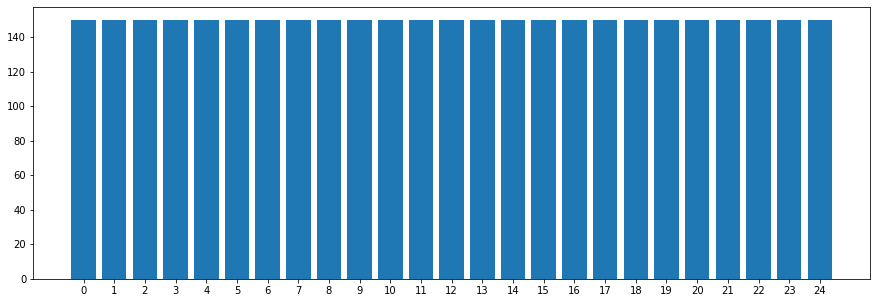

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

balanced_train_labels_df = pd.Series(balanced_train_labels)
plt, ax = plt.subplots(figsize=(15,5))
p = ax.bar(x = balanced_train_labels_df.value_counts().index, 
           height= balanced_train_labels_df.value_counts(),
           tick_label = balanced_train_labels_df.value_counts().index)
# ax.bar_label(p, balanced_train_labels_df.value_counts())

모든 label에 해당하는 data의 개수를 150으로 맞춰주었다

In [26]:
class CustomDataset(Dataset):
    def __init__(self, train_img, train_label, transforms=None):
        self.imgs = train_img
        self.labels = train_label
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, target
    
trainDataset = CustomDataset(balanced_train_jpg, balanced_train_labels, transforms = data_transforms['train'])
trainDataloader = DataLoader(
    trainDataset, batch_size=CONFIG['train_batch_size'], shuffle=True)

validDataset = CustomDataset(valid_jpg, valid_labels, transforms = data_transforms['valid'])
validDataloader = DataLoader(validDataset, batch_size = CONFIG['valid_batch_size'], shuffle = True)

In [25]:
for img, target in trainDataset:
  print(img.shape)
  print(target)
  break
for img, target in trainDataloader:
  print(img.shape)
  print(target)
  break

torch.Size([3, 384, 384])
0
torch.Size([8, 3, 384, 384])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [1]:
# # Cross Validation

# from sklearn.model_selection import StratifiedKFold
# train_datasets = []
# valid_datasets = []
# train_dataloaders = []
# valid_dataloaders = []

# skf = StratifiedKFold(n_splits = 5)

# for step, (train_index, val_index) in enumerate(skf.split(X = train_jpg, y= train_labels)):
#     X_train = train_jpg[train_index]
#     y_train = train_labels[train_index]
#     X_val = train_jpg[val_index]
#     y_val = train_labels[val_index]
#     train_datasets.append(CustomDataset(
#         X_train, y_train, transforms=data_transforms['train']))
#     valid_datasets.append(CustomDataset(
#         X_val, y_val, transforms=data_transforms['valid']))
#     train_dataloaders.append(DataLoader(
#         train_datasets[step], batch_size=CONFIG['train_batch_size'], shuffle=True)
#     )
#     valid_dataloaders.append(
#         DataLoader(
#             valid_datasets[step], batch_size=CONFIG['valid_batch_size'], shuffle=True)
#     )
